 # Odor Decoding Analysis



 This notebook contains analysis code for decoding odor responses from neural data.

In [1]:
#######################################################################
# IMPORTS AND SETUP
#######################################################################
import json
import logging
import pathlib
import re
from itertools import combinations

import numpy as np
import pandas as pd
import seaborn as sns

# plotting libraries
from matplotlib import pyplot as plt

# stats
from scipy import stats

# machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


#######################################################################
# DATA LOADING UTILITIES
#######################################################################
def load_data(data_dir):
    """
    Load and preprocess odor response data from CSV files.

    Args:
        data_dir: Path to directory containing CSV data files and odor mapping

    Returns:
        Preprocessed DataFrame with features and metadata
    """
    odor_mapping = json.load(
        open(data_dir / "odor_mapping.json", "r")
    )  # load odor mapping from json file
    odor_mapping = {int(k): v for k, v in odor_mapping.items()}  # convert keys to int
    # load data
    data = []
    for filename in pathlib.Path(data_dir).glob("*.csv"):
        _data = pd.read_csv(filename, header=None)  # load csv file
        _data.columns = [f"feature_{i}" for i in range(len(_data.columns) - 1)] + [
            "odor"
        ]  # rename columns
        _data["exp"] = filename.stem  # log experiment name as file name
        _data["animal"] = filename.stem.split("_")[0]
        # extract before or after condition with regex (two characters after "odor")
        _data["condition"] = re.findall(r"(?<=odor).{2}", filename.stem)[0]
        data.append(_data)
        logging.info(f"loaded dataset: {filename}")
    data = pd.concat(data)
    data["odor"] = data["odor"].map(odor_mapping)  # map odor numbers to names
    data["odor"] = pd.Categorical(
        data["odor"], categories=odor_mapping.values(), ordered=True
    )  # convert odor to categorical variable
    data = data.dropna(subset=["odor"])
    return data


#######################################################################
# MODEL TRAINING AND EVALUATION
#######################################################################
def logistic_regression_performance(data, rng=np.random.default_rng(0)):
    """
    Fit a vanilla logistic regression and report f1 score per odor and overall accuracy score
    Fitted model is not saved or returned!

    Args:
        data: pd.DataFrame  # dataframe with columns 'odor', 'exp' and a number of 'feature' columns,
        'odor' column is the prediction target,
        columns prefixed with 'feature' will be used as predictors of the regression model,
        'exp' column is kept for record keeping purposes
        rng: numpy.random._generator.Generator  # random generator used in cross validation, fix it to reproduce the same results

    Return:
        f1score_df: pd.DataFrame  # dataframe recording cross validated f1 scores, each row is one cross validation sample
        accuracy_df: pd.DataFrame  # dataframe recording cross validated accuracy scores
    """
    # split data to X and y
    X = data.filter(like="feature").to_numpy()
    y = data.odor.to_numpy()
    # data quality control
    unique_odor, counts = np.unique(y, return_counts=True)
    assert len(np.unique(counts)) == 1, "Imbalanced experimental design!"
    assert data.exp.nunique() == 1, "More than one experiment is found!"
    assert data.isna().sum().sum() == 0, "NaN values found in dataset!"
    # log information about the dataset
    logging.info(
        "There are %d trials where %d odors are presented %d times",
        len(y),
        len(unique_odor),
        np.unique(counts)[0],
    )
    logging.info(
        "%d features were extracted from population neural responses",
        X.shape[1],
    )
    # configure model
    model = make_pipeline(
        StandardScaler(), LogisticRegression()
    )  # classification pipeline combines a standardization step (substract by mean and divide by std) and a vanilla logistic regression model
    # estimate variance of model performance through 5x2 cross validation
    cv = RepeatedStratifiedKFold(
        n_splits=2, n_repeats=5, random_state=np.random.RandomState(rng.bit_generator)
    )
    f1score = []
    accuracy = []
    true_labels = []  # List to store true labels
    pred_labels = []  # List to store predicted labels
    for train_idx, test_idx in cv.split(X, y):
        # train model on the training set
        model = model.fit(X[train_idx], y[train_idx])
        true_labels.extend(y[test_idx])
        # obtain predicted labels
        pred_labels.extend(model.predict(X[test_idx]))
        # evaluate on test set
        f1score.append(f1_score(y[test_idx], model.predict(X[test_idx]), average=None))
        accuracy.append(accuracy_score(y[test_idx], model.predict(X[test_idx])))
    f1score = np.stack(f1score)
    accuracy = np.stack(accuracy)
    f1score_df = pd.DataFrame(
        data=f1score,
        index=np.arange(f1score.shape[0]),
        columns=model.classes_,
    )
    f1score_df = pd.melt(f1score_df, var_name="odor", value_name="f1_score")
    f1score_df["odor"] = pd.Categorical(f1score_df["odor"])
    f1score_df["exp"] = data.exp.unique()[0]
    accuracy_df = pd.Series(accuracy).to_frame("accuracy")
    accuracy_df["exp"] = data.exp.unique()[0]
    return f1score_df, accuracy_df, true_labels, pred_labels


#######################################################################
# DECODING FRAMEWORKS
#######################################################################
def multi_class_decoding_performance(data, rng_seed):
    """
    Perform multi-class odor decoding and evaluate performance.

    Args:
        data: DataFrame containing features and odor labels
        rng_seed: Random seed for reproducibility

    Returns:
        Tuple of DataFrames with f1 scores, accuracy, and label lists
    """
    # random number generator used for all downstream analysis
    rng = np.random.default_rng(rng_seed)

    # Initialize lists to store performance metrics for all odor combinations
    all_f1score_df = []
    all_accuracy_df = []
    all_true_labels = []
    all_pred_labels = []

    # Loop over all experiments
    for (exp, animal, condition), exp_data in data.groupby([
        "exp",
        "animal",
        "condition",
    ]):
        logging.info(f"Training models for {exp}:")
        # Get model performance using logistic_regression_performance function
        exp_data = exp_data.dropna(axis=1)
        f1score_df, accuracy_df, true_labels, pred_labels = (
            logistic_regression_performance(exp_data, rng)
        )
        # Append the results to the lists
        all_f1score_df.append(
            f1score_df.assign(
                animal=animal,
                condition=condition,
            )
        )
        all_accuracy_df.append(
            accuracy_df.assign(
                animal=animal,
                condition=condition,
            )
        )
        all_true_labels.extend(true_labels)
        all_pred_labels.extend(pred_labels)

    # Concatenate all results into single DataFrames
    all_f1score_df = pd.concat(all_f1score_df)
    all_accuracy_df = pd.concat(all_accuracy_df)

    return all_f1score_df, all_accuracy_df, all_true_labels, all_pred_labels


def binary_decoding_performance(data, rng_seed):
    """
    Perform binary odor decoding for all pairwise combinations and evaluate performance.

    Args:
        data: DataFrame containing features and odor labels
        rng_seed: Random seed for reproducibility

    Returns:
        DataFrame with mean accuracy for each odor pair
    """
    # random number generator used for all downstream analysis
    rng = np.random.default_rng(rng_seed)

    # Initialize lists to store performance metrics for all odor combinations
    all_f1score_df = []
    all_accuracy_df = []

    for (exp, animal, condition), exp_data in data.groupby([
        "exp",
        "animal",
        "condition",
    ]):
        logging.info(f"Training models for {exp}:")
        exp_data = exp_data.dropna(axis=1)
        # Loop over all possible combinations of 2 out of 4 odors
        for odor1, odor2 in combinations(exp_data.odor.cat.categories, 2):
            # Prepare data for logistic regression
            odor_data = exp_data.query("odor == @odor1 | odor == @odor2")
            # Get model performance using logistic_regression_performance function
            f1score_df, accuracy_df, _, _ = logistic_regression_performance(
                odor_data, rng
            )
            # Append the results to the lists
            all_f1score_df.append(
                f1score_df.assign(
                    odor1=odor1,
                    odor2=odor2,
                    comp=f"{odor1}\n{odor2}",
                    animal=animal,
                    condition=condition,
                )
            )
            all_accuracy_df.append(
                accuracy_df.assign(
                    odor1=odor1,
                    odor2=odor2,
                    comp=f"{odor1}\n{odor2}",
                    animal=animal,
                    condition=condition,
                )
            )

    # Concatenate all results into single DataFrames
    all_accuracy_df = pd.concat(all_accuracy_df)
    mean_accuracy_df = (
        all_accuracy_df.groupby(["animal", "comp", "condition"])["accuracy"]
        .mean()
        .reset_index()
    )

    # correct the odor pair order
    def from_odor_to_num(odor):
        # get the category code of the odor
        return data.odor.cat.categories.get_loc(odor)

    def from_odor_pair_to_num(odor_pair):
        # reverse mapping of odor pairs to numbers
        return "".join([str(from_odor_to_num(odor)) for odor in odor_pair.split("\n")])

    all_odor_pairs = all_accuracy_df["comp"].unique()
    mean_accuracy_df["comp"] = pd.Categorical(
        mean_accuracy_df["comp"],
        categories=all_odor_pairs[
            np.argsort([
                from_odor_pair_to_num(odor_pair) for odor_pair in all_odor_pairs
            ])
        ],
        ordered=True,
    )

    return mean_accuracy_df


 ## Analysis 1: Multi-Class Confusion Matrices



 Computing confusion matrices for multi-class classification before and after conditioning.

In [2]:
# Define data paths - NOTE: Adjust these paths to match your local directory structure
data_path = pathlib.Path("/src/vGlut2BF_odor_learning/data")

# Compute confusion matrix with multi-class classification before conditioning
bf_data_dir = data_path / "2secondsafonset_bfcondition_MOsubtracted"
bf_data = load_data(bf_data_dir)
_, _, bf_true_labels, bf_pred_labels = multi_class_decoding_performance(
    bf_data, rng_seed=0
)
bf_confusion_matrix = confusion_matrix(
    bf_true_labels, bf_pred_labels, labels=bf_data.odor.cat.categories
)

# Compute confusion matrix with multi-class classification after conditioning
af_data_dir = data_path / "2secondsafonset_afcondition_MOsubtracted"
af_data = load_data(af_data_dir)
af_f1score_df, af_accuracy_df, af_true_labels, af_pred_labels = (
    multi_class_decoding_performance(af_data, rng_seed=0)
)
af_confusion_matrix = confusion_matrix(
    af_true_labels, af_pred_labels, labels=af_data.odor.cat.categories
)

assert (bf_data.odor.cat.categories == af_data.odor.cat.categories).all(), (
    "Odor categories do not match between before and after conditioning datasets"
)


 ### Visualizing the Confusion Matrices



 Comparing classification performance before and after conditioning

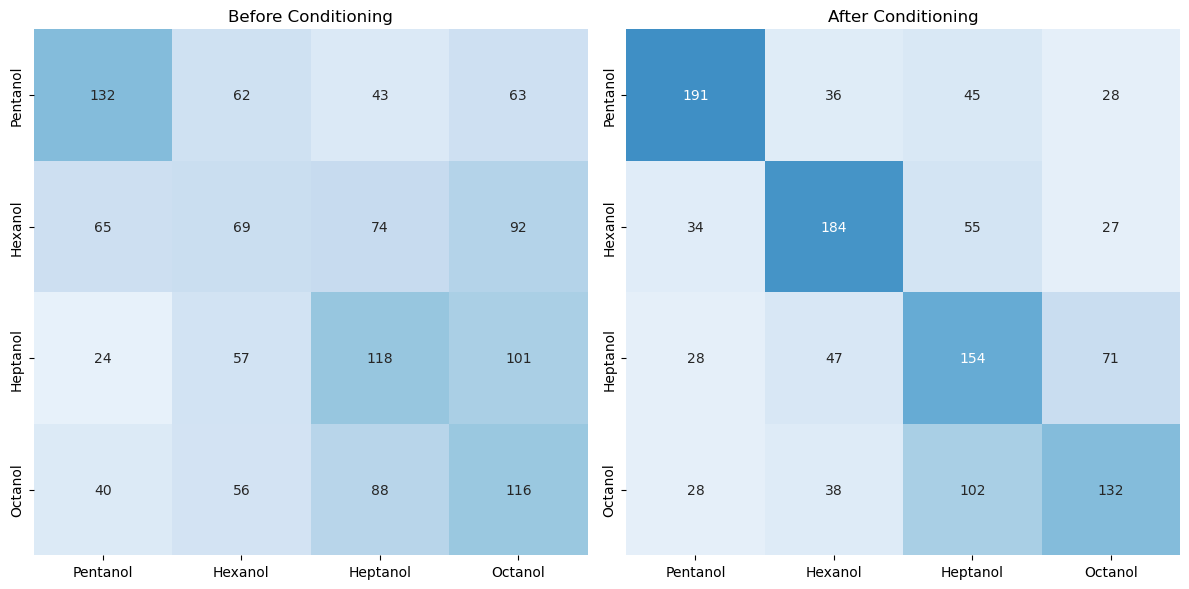

In [3]:
# Visualize confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(
    bf_confusion_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    ax=ax[0],
    xticklabels=bf_data.odor.cat.categories,
    yticklabels=bf_data.odor.cat.categories,
    vmin=0,
    vmax=300,
)
ax[0].set_title("Before Conditioning")
sns.heatmap(
    af_confusion_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    ax=ax[1],
    xticklabels=af_data.odor.cat.categories,
    yticklabels=af_data.odor.cat.categories,
    vmin=0,
    vmax=300,
)
ax[1].set_title("After Conditioning")
plt.tight_layout()


 ## Analysis 2: Binary Decoding Performance Comparison



 Comparing binary classification performance before and after conditioning

In [4]:
# Compute binary decoding performance before conditioning
bf_data_dir = data_path / "2secondsafonset_bfcondition_MOsubtracted"
bf_data = load_data(bf_data_dir)
bf_accuracy = binary_decoding_performance(bf_data, rng_seed=0)

# Compute binary decoding performance after conditioning
af_data_dir = data_path / "2secondsafonset_afcondition_MOsubtracted"
af_data = load_data(af_data_dir)
af_accuracy = binary_decoding_performance(af_data, rng_seed=0)

# Combine datasets for comparison
mean_accuracy_df = pd.concat([bf_accuracy, af_accuracy])


 ## Statistical Analysis and Visualization



 Performing statistical tests and visualizing the results

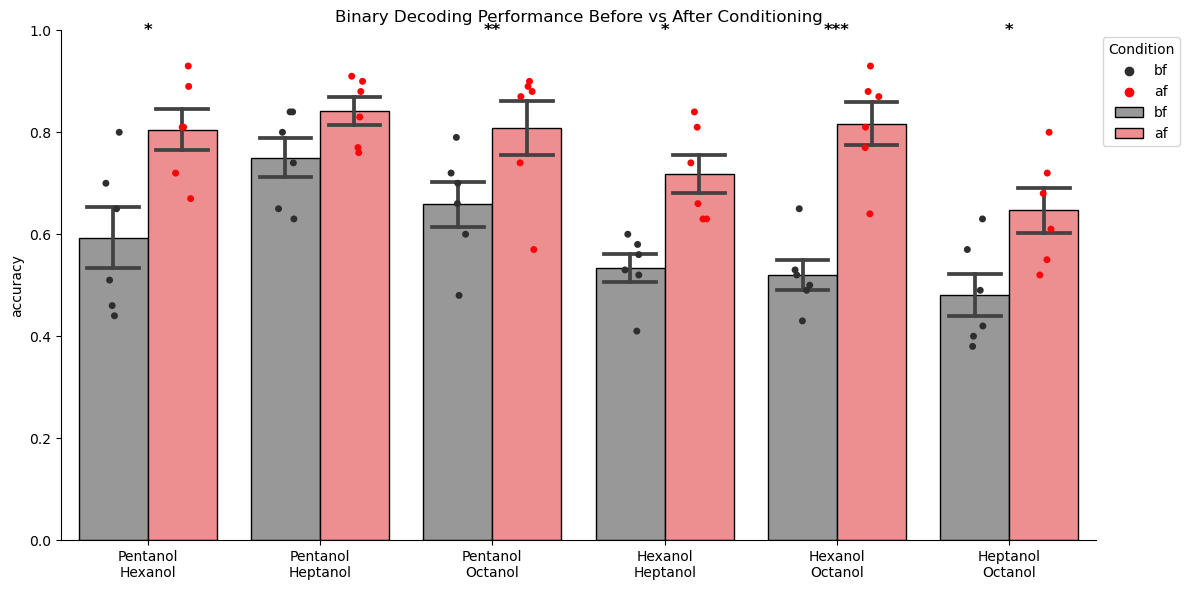

In [5]:
# Perform pairwise t-tests between before and after conditions for each odor pair
ttest_results = mean_accuracy_df.groupby("comp").apply(
    lambda x: pd.Series(
        stats.ttest_rel(
            x.query("condition == 'bf'")["accuracy"],
            x.query("condition == 'af'")["accuracy"],
        ),
        index=["t_statistic", "p_value"],
    )
)


# Helper function to convert p-values to significance stars
def p2stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""


# Create visualization
plt.figure(figsize=(12, 6))
sns.barplot(
    data=mean_accuracy_df,
    x="comp",
    y="accuracy",
    hue="condition",
    # change color palette to grey and red
    palette={"bf": "#989898", "af": "#FD7F82"},
    hue_order=["bf", "af"],
    # add black frame around bars
    edgecolor="black",
    errorbar="se",
    # add caps to error bars
    capsize=0.3,
)
plt.ylim(0, 1)
sns.stripplot(
    data=mean_accuracy_df,
    x="comp",
    y="accuracy",
    hue="condition",
    palette={"bf": "#2E2E2E", "af": "#FC0307"},
    hue_order=["bf", "af"],
    dodge=True,
)

# add asterisks for significant differences
for i, (_, row) in enumerate(ttest_results.iterrows()):
    if row["p_value"] < 0.05:
        plt.text(
            i,
            1,
            p2stars(row["p_value"]),
            ha="center",
            va="center",
            color="black",
            fontsize=12,
            fontweight="bold",
        )

# legend outside of the plot
plt.legend(title="Condition", bbox_to_anchor=(1, 1), loc="upper left")
plt.xlabel("")
plt.title("Binary Decoding Performance Before vs After Conditioning")
sns.despine()
plt.tight_layout()
